In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torchvision.io import read_image

from src.detections_generation import import_from_hdf5
from src.features_generation import H5_FILE, FRAME_FOLDER

# Visualize and extraction of bboxes on a single frame

To compute image features from bboxes, we would like to extract bboxes area from frame. 

Although, I am not sure about the bound of bboxes coordinates and the frame dimension.

So in this notebook, we will take one detection result from H5 file and we will plot them. Also, we will test the code to extract the region of interest.

In [33]:
frame_to_detection = list(import_from_hdf5(H5_FILE, FRAME_FOLDER).items())


In [34]:
frame, detection = frame_to_detection[4]

In [35]:
frame, detection.scores.shape, detection.bboxes.shape

(PosixPath('/home/reusm/data/frames/s10019.jpg'),
 torch.Size([100]),
 torch.Size([100, 4]))

In [36]:
frame_tensor = read_image(str(frame))
frame_tensor.shape

torch.Size([3, 800, 600])

Check if every bboxes fits in frame shape

In [37]:
detection.bboxes[0]

tensor([465.2788, 126.2245, 508.5058, 257.1483])

In [38]:
all(
    all( 
        coord <= frame_tensor.shape[2]
        if i % 2
        else coord <= frame_tensor.shape[1]
        for coord,i in enumerate(bbox)
    )
    for bbox in detection.bboxes
)

True

In [39]:
bboxes = [
    frame_tensor[:,int(bbox[0]):int(bbox[2]), int(bbox[1]):int(bbox[3])]
    for bbox in detection.bboxes
]

**NOTE**: I updated the H5 file so now the output is correct, before the bboxes were random and too big. The rest of the notebook is not updated.

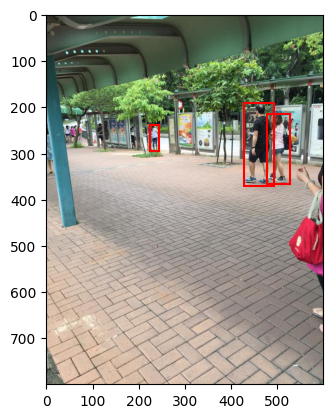

In [40]:
def plot_bbox(frame_to_detection, i, threshold):
    frame, detection = frame_to_detection[i]

    plt.figure()
    plt.imshow(plt.imread(str(frame)))
    for bbox, score in zip(detection.bboxes, detection.scores):
        if score >= threshold:
            plt.gca().add_patch(Rectangle(
                (bbox[0], bbox[1]), 
                bbox[2] - bbox[0], 
                bbox[3] - bbox[1],
                edgecolor='red',
                facecolor='none',
                lw=1.5
            ))
    plt.show()
plot_bbox(frame_to_detection, 13, .77)

For any value of `i`, so any frame, it seems that the bboxes are too big!

In [24]:
heights = np.array([
    bbox[3] - bbox[1]
    for bbox in detection.bboxes
])
widths = np.array([
    bbox[2] - bbox[0]
    for bbox in detection.bboxes
])
print(
    f"{'Width stats':-^50s}\n"
    f"{int(widths.mean()) = :_d}, "
    f"{int(widths.std()) = :_d}\n"
    f"{'Height stats':-^50s}\n"
    f"{int(heights.mean()) = :_d}, "
    f"{int(heights.std()) = :_d}\n"
)

-------------------Width stats--------------------
int(widths.mean()) = 309, int(widths.std()) = 7
-------------------Height stats-------------------
int(heights.mean()) = 416, int(heights.std()) = 9



On average, we have bboxes of size 309x416, which is way too big. Maybe there is a problem with the bboxes resize somewhere?

If it's the case, they might be bboxes outside of the frame limit, for this, we are going to check that for every bboxes of every detections.

In [25]:
all_bboxes = [detection.bboxes for _, detection in frame_to_detection]

In [29]:
all(
    all(
        all(
            coord <= frame_tensor.shape[2]
            if i % 2
            else coord <= frame_tensor.shape[1]
            for coord, i in enumerate(bbox)
        )
        # For each bbox in one frame
        for bbox in bboxes
    )
    # For each frame
    for bboxes in all_bboxes
)

True

In [32]:
all_bboxes[:][0], frame_tensor.shape

(tensor([[149.6013, 147.9013, 460.3232, 563.1409],
         [233.8384,  14.6477, 536.0672, 429.9266],
         [108.9551,   0.0000, 406.6408, 416.6662],
         [145.9089, 130.6689, 453.0125, 543.5410],
         [186.8664, 243.7865, 497.7298, 665.1698],
         [102.1382,  46.7028, 415.0243, 466.1554],
         [ 38.1566,  77.3939, 352.0288, 495.1064],
         [247.7938,  52.5516, 551.7463, 476.2946],
         [ 87.9629,   0.0000, 390.8256, 389.9119],
         [239.1842,   0.0000, 547.0887, 361.4959],
         [  1.6655,  19.3710, 312.9589, 444.9718],
         [149.4978,   0.0000, 456.1067, 405.7325],
         [154.5824,  28.2248, 466.8325, 447.0963],
         [228.7090, 260.4369, 534.9871, 684.6309],
         [174.4877,   0.0000, 478.9476, 380.0449],
         [298.6346,  84.5819, 600.0000, 498.8140],
         [196.0979, 166.0373, 507.4530, 581.9655],
         [185.2841, 232.7237, 499.3259, 656.3823],
         [273.7632, 235.8622, 582.9987, 649.6379],
         [ 72.5800,  34.5112, 3